In [1]:
import os
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns

# Set working directory
os.chdir("P:/Tolulope/Cellranger Results/Fry-Murach 4d OV aged")

In [2]:
import scvi
import scanpy as sc

from matplotlib.pyplot import rc_context
sc.set_figure_params(dpi=100)

import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

C:\Users\tpsa222\.conda\envs\scvi-tools-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define sample paths
sample_paths = {
    'V1': 'P:/Tolulope/Cellranger Results/Fry-Murach 4d OV aged/v1/outs/filtered_feature_bc_matrix',
    'V2': 'P:/Tolulope/Cellranger Results/Fry-Murach 4d OV aged/v2/outs/filtered_feature_bc_matrix',
    'T1': 'P:/Tolulope/Cellranger Results/Fry-Murach 4d OV aged/t1/outs/filtered_feature_bc_matrix',
    'T2': 'P:/Tolulope/Cellranger Results/Fry-Murach 4d OV aged/t2/outs/filtered_feature_bc_matrix'
}

# Load AnnData objects
adata1 = sc.read_10x_mtx(sample_paths['V1'])
adata2 = sc.read_10x_mtx(sample_paths['V2'])
adata3 = sc.read_10x_mtx(sample_paths['T1'])
adata4 = sc.read_10x_mtx(sample_paths['T2'])


In [4]:
#sample 1
adata1

AnnData object with n_obs × n_vars = 4957 × 41464
    var: 'gene_ids', 'feature_types'

In [5]:
sc.pp.filter_genes(adata1, min_cells = 10)
sc.pp.highly_variable_genes(adata1, n_top_genes = 3000, subset = True, flavor = 'seurat_v3')

In [6]:
scvi.model.SCVI.setup_anndata(adata1)
vae = scvi.model.SCVI(adata1)
vae.train()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█████| 400/400 [06:27<00:00,  1.02it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [06:27<00:00,  1.03it/s, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=1.12e+3]


In [7]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 346/400:  86%|███████▊ | 346/400 [01:22<00:12,  4.22it/s, v_num=1, train_loss_step=0.459, train_loss_epoch=0.325]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.297. Signaling Trainer to stop.


In [8]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df

doublet   singlet prediction
AAACCCAAGCCTTGAT-1  0.740581  0.259419    doublet
AAACCCAAGTTCCATG-1  0.122721  0.877279    singlet
AAACCCACAGCTATAC-1  0.281624  0.718376    singlet
AAACCCAGTCCTGTCT-1  0.517818  0.482182    doublet
AAACCCAGTTTGGCTA-1  0.325991  0.674009    singlet
...                      ...       ...        ...
TTTGTTGAGTGCAGGT-1  0.117677  0.882323    singlet
TTTGTTGCACAGCCAC-1  0.154365  0.845635    singlet
TTTGTTGCATCGGAAG-1  0.932540  0.067460    doublet
TTTGTTGTCACGGACC-1  0.464915  0.535085    singlet
TTTGTTGTCAGTGTGT-1  0.080566  0.919434    singlet

[4957 rows x 3 columns]

In [9]:
df.groupby('prediction').count()

doublet  singlet
prediction                  
doublet         858      858
singlet        4099     4099

In [10]:
df['dif'] = df.doublet - df.singlet
df

doublet   singlet prediction       dif
AAACCCAAGCCTTGAT-1  0.740581  0.259419    doublet  0.481162
AAACCCAAGTTCCATG-1  0.122721  0.877279    singlet -0.754557
AAACCCACAGCTATAC-1  0.281624  0.718376    singlet -0.436752
AAACCCAGTCCTGTCT-1  0.517818  0.482182    doublet  0.035637
AAACCCAGTTTGGCTA-1  0.325991  0.674009    singlet -0.348019
...                      ...       ...        ...       ...
TTTGTTGAGTGCAGGT-1  0.117677  0.882323    singlet -0.764645
TTTGTTGCACAGCCAC-1  0.154365  0.845635    singlet -0.691270
TTTGTTGCATCGGAAG-1  0.932540  0.067460    doublet  0.865081
TTTGTTGTCACGGACC-1  0.464915  0.535085    singlet -0.070169
TTTGTTGTCAGTGTGT-1  0.080566  0.919434    singlet -0.838867

[4957 rows x 4 columns]

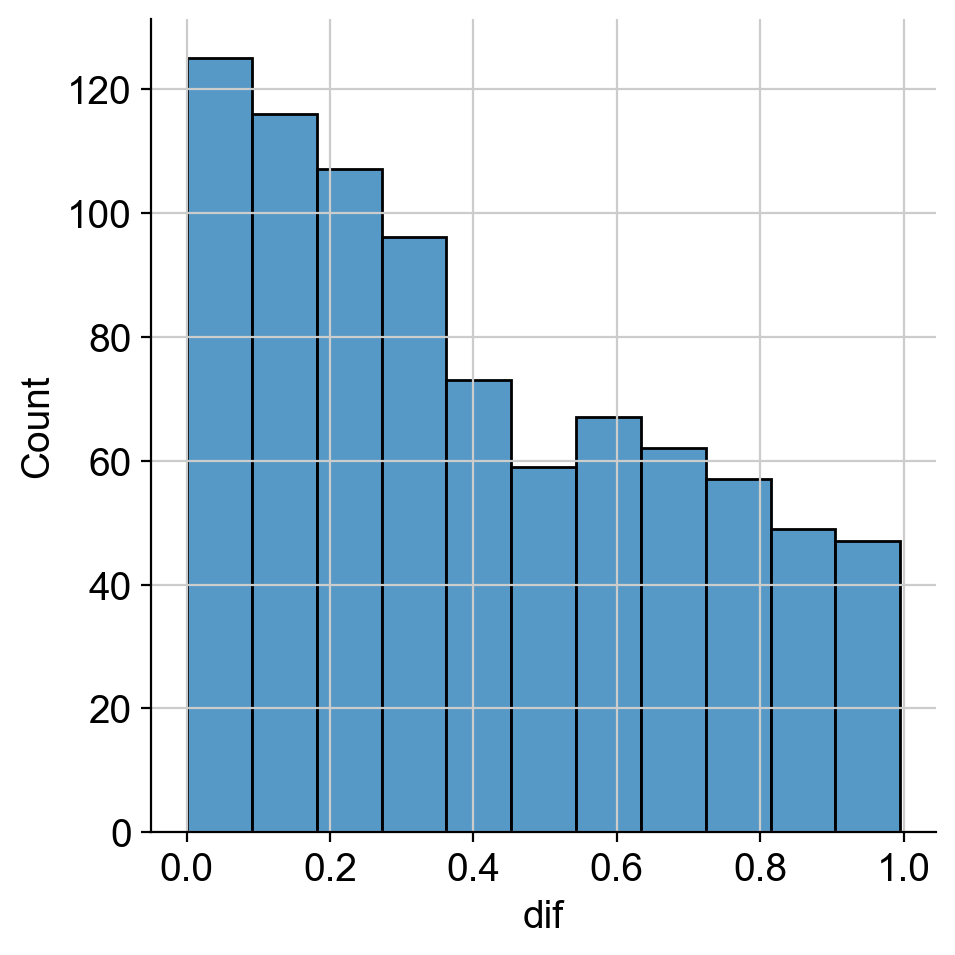

In [11]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [12]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 0.4)]
doublets

doublet   singlet prediction       dif
AAACCCAAGCCTTGAT-1  0.740581  0.259419    doublet  0.481162
AAACGAATCTGCGATA-1  0.862832  0.137168    doublet  0.725665
AAACGCTGTACCGGCT-1  0.865207  0.134793    doublet  0.730414
AAAGGGCTCTCAGGCG-1  0.755827  0.244173    doublet  0.511653
AAAGTGAGTGTTCAGT-1  0.891225  0.108775    doublet  0.782449
...                      ...       ...        ...       ...
TTTCACATCATCGACA-1  0.815380  0.184620    doublet  0.630760
TTTCATGGTATGCGGA-1  0.845149  0.154851    doublet  0.690298
TTTGACTCAGCAATTC-1  0.997749  0.002251    doublet  0.995498
TTTGGAGTCCCTCGAT-1  0.702574  0.297426    doublet  0.405148
TTTGTTGCATCGGAAG-1  0.932540  0.067460    doublet  0.865081

[380 rows x 4 columns]

In [13]:
adata1

AnnData object with n_obs × n_vars = 4957 × 3000
    obs: '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'

In [14]:
# Define sample paths
sample_paths = {
    'V1': 'P:/Tolulope/Cellranger Results/Fry-Murach 4d OV aged/v1/outs/filtered_feature_bc_matrix',
    
}

# Load AnnData objects

adata1 = sc.read_10x_mtx(sample_paths['V1'])


In [15]:
adata1.obs

Empty DataFrame
Columns: []
Index: [AAACCCAAGCCTTGAT-1, AAACCCAAGTTCCATG-1, AAACCCACAGCTATAC-1, AAACCCAGTCCTGTCT-1, AAACCCAGTTTGGCTA-1, AAACCCATCCATCTGC-1, AAACCCATCTGCGATA-1, AAACGAAAGCACTCAT-1, AAACGAATCCACCTCA-1, AAACGAATCCCAGCGA-1, AAACGAATCGCACTCT-1, AAACGAATCTAGACAC-1, AAACGAATCTGCGATA-1, AAACGAATCTTCGTGC-1, AAACGCTAGACAGCGT-1, AAACGCTGTACCGGCT-1, AAACGCTTCCCAGGAC-1, AAACGCTTCTCTTAAC-1, AAAGAACAGATGTAGT-1, AAAGAACAGGCCTTCG-1, AAAGAACTCAAGCCAT-1, AAAGAACTCGTTGTTT-1, AAAGGATAGAGTCAAT-1, AAAGGATCAGCGTTTA-1, AAAGGATTCACTTGGA-1, AAAGGGCAGACTAGAT-1, AAAGGGCAGCACCCAC-1, AAAGGGCGTTATAGCC-1, AAAGGGCTCCATTGCC-1, AAAGGGCTCCGCCTAT-1, AAAGGGCTCGGAATTC-1, AAAGGGCTCTCAGGCG-1, AAAGGTAAGAGGCGGA-1, AAAGGTAAGCGCGTTC-1, AAAGGTACAATAGGAT-1, AAAGGTACAGAGGCTA-1, AAAGGTAGTAGGACCA-1, AAAGGTATCATGACAC-1, AAAGGTATCGCATAGT-1, AAAGTCCAGAGATTCA-1, AAAGTCCCACAATGCT-1, AAAGTCCGTTCAATCG-1, AAAGTCCTCGAACTCA-1, AAAGTCCTCTGAGATC-1, AAAGTGAAGCATCGAG-1, AAAGTGACACAACCGC-1, AAAGTGAGTGTTCAGT-1, AAAGTGATCGTCACCT-1, AAAGTGATCTGACAGT-1, AAATGGAAGAGGGTGG-1, AAATGGAAGATACGAT-1, AAATGGAAGCCAGAGT-1, AAATGGACACCCTGTT-1, AAATGGACAGAGCGTA-1, AAATGGACAGGTATGG-1, AAATGGAGTACGATCT-1, AAATGGAGTAGTTAGA-1, AAATGGAGTTGCATCA-1, AAATGGATCTTAGCTT-1, AACAAAGAGCTCTTCC-1, AACAAAGAGGAGATAG-1, AACAAAGCAGGTTCGC-1, AACAAAGCATGGTGGA-1, AACAAAGGTCCGGACT-1, AACAAAGTCGGTCTGG-1, AACAACCAGCGTACAG-1, AACAACCAGTTTGGCT-1, AACAACCCACACGGAA-1, AACAACCTCCAACACA-1, AACAAGACAACTGCCG-1, AACAAGACAAGCCTGC-1, AACAAGAGTCTGCCTT-1, AACAAGATCAAACCTG-1, AACAAGATCATAGACC-1, AACACACAGCAACTTC-1, AACACACGTGATAGAT-1, AACACACGTGGACCAA-1, AACACACGTTGAGGAC-1, AACACACTCGCCAATA-1, AACAGGGAGCTCCACG-1, AACAGGGCAAGGTACG-1, AACAGGGCAGAGATTA-1, AACAGGGCAGGCTATT-1, AACCAACAGTAGACCG-1, AACCAACCAATACAGA-1, AACCAACCACAAGTGG-1, AACCAACCAGAATTCC-1, AACCAACGTGTGTACT-1, AACCAACTCCGACGGT-1, AACCAACTCTCTAGGA-1, AACCACAAGATACCAA-1, AACCACACAAAGCGTG-1, AACCACACAATTTCTC-1, AACCACAGTACTCGCG-1, AACCACAGTGCTCCGA-1, AACCACAGTGTCTAAC-1, AACCATGAGAAGTCTA-1, AACCATGAGCAAGTCG-1, AACCATGAGCTAGAAT-1, AACCATGAGTGGTGGT-1, ...]

[4957 rows x 0 columns]

In [16]:
adata1.obs['doublet'] = adata1.obs.index.isin(doublets.index) 

In [17]:
adata1.obs

doublet
AAACCCAAGCCTTGAT-1     True
AAACCCAAGTTCCATG-1    False
AAACCCACAGCTATAC-1    False
AAACCCAGTCCTGTCT-1    False
AAACCCAGTTTGGCTA-1    False
...                     ...
TTTGTTGAGTGCAGGT-1    False
TTTGTTGCACAGCCAC-1    False
TTTGTTGCATCGGAAG-1     True
TTTGTTGTCACGGACC-1    False
TTTGTTGTCAGTGTGT-1    False

[4957 rows x 1 columns]

In [18]:
adata1 = adata1[~adata1.obs.doublet]
adata1

View of AnnData object with n_obs × n_vars = 4577 × 41464
    obs: 'doublet'
    var: 'gene_ids', 'feature_types'

In [19]:
#sample2
adata2

AnnData object with n_obs × n_vars = 4570 × 41464
    var: 'gene_ids', 'feature_types'

In [20]:
sc.pp.filter_genes(adata2, min_cells = 10)
sc.pp.highly_variable_genes(adata2, n_top_genes = 3000, subset = True, flavor = 'seurat_v3')

In [21]:
scvi.model.SCVI.setup_anndata(adata2)
vae = scvi.model.SCVI(adata2)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█████| 400/400 [06:02<00:00,  1.09it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.12e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [06:02<00:00,  1.10it/s, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.12e+3]


In [22]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 313/400:  78%|███████▊  | 313/400 [01:10<00:19,  4.47it/s, v_num=1, train_loss_step=0.343, train_loss_epoch=0.34]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.339. Signaling Trainer to stop.


In [23]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df

doublet   singlet prediction
AAACCCAGTGGGTCAA-1  0.016898  0.983102    singlet
AAACGAAAGAGAGAAC-1  0.255387  0.744613    singlet
AAACGAAAGTAGGAAG-1  0.278942  0.721058    singlet
AAACGAACAGAGATGC-1  0.001431  0.998569    singlet
AAACGAACAGCGTGAA-1  0.725141  0.274859    doublet
...                      ...       ...        ...
TTTGGTTGTGTGACCC-1  0.256797  0.743203    singlet
TTTGTTGGTACAGAAT-1  0.172610  0.827390    singlet
TTTGTTGGTTAGCGGA-1  0.051160  0.948840    singlet
TTTGTTGTCATCGACA-1  0.221217  0.778783    singlet
TTTGTTGTCTATCCAT-1  0.165581  0.834419    singlet

[4570 rows x 3 columns]

In [24]:
df.groupby('prediction').count()

doublet  singlet
prediction                  
doublet        1205     1205
singlet        3365     3365

In [25]:
df['dif'] = df.doublet - df.singlet
df

doublet   singlet prediction       dif
AAACCCAGTGGGTCAA-1  0.016898  0.983102    singlet -0.966205
AAACGAAAGAGAGAAC-1  0.255387  0.744613    singlet -0.489226
AAACGAAAGTAGGAAG-1  0.278942  0.721058    singlet -0.442115
AAACGAACAGAGATGC-1  0.001431  0.998569    singlet -0.997137
AAACGAACAGCGTGAA-1  0.725141  0.274859    doublet  0.450283
...                      ...       ...        ...       ...
TTTGGTTGTGTGACCC-1  0.256797  0.743203    singlet -0.486406
TTTGTTGGTACAGAAT-1  0.172610  0.827390    singlet -0.654779
TTTGTTGGTTAGCGGA-1  0.051160  0.948840    singlet -0.897681
TTTGTTGTCATCGACA-1  0.221217  0.778783    singlet -0.557565
TTTGTTGTCTATCCAT-1  0.165581  0.834419    singlet -0.668838

[4570 rows x 4 columns]

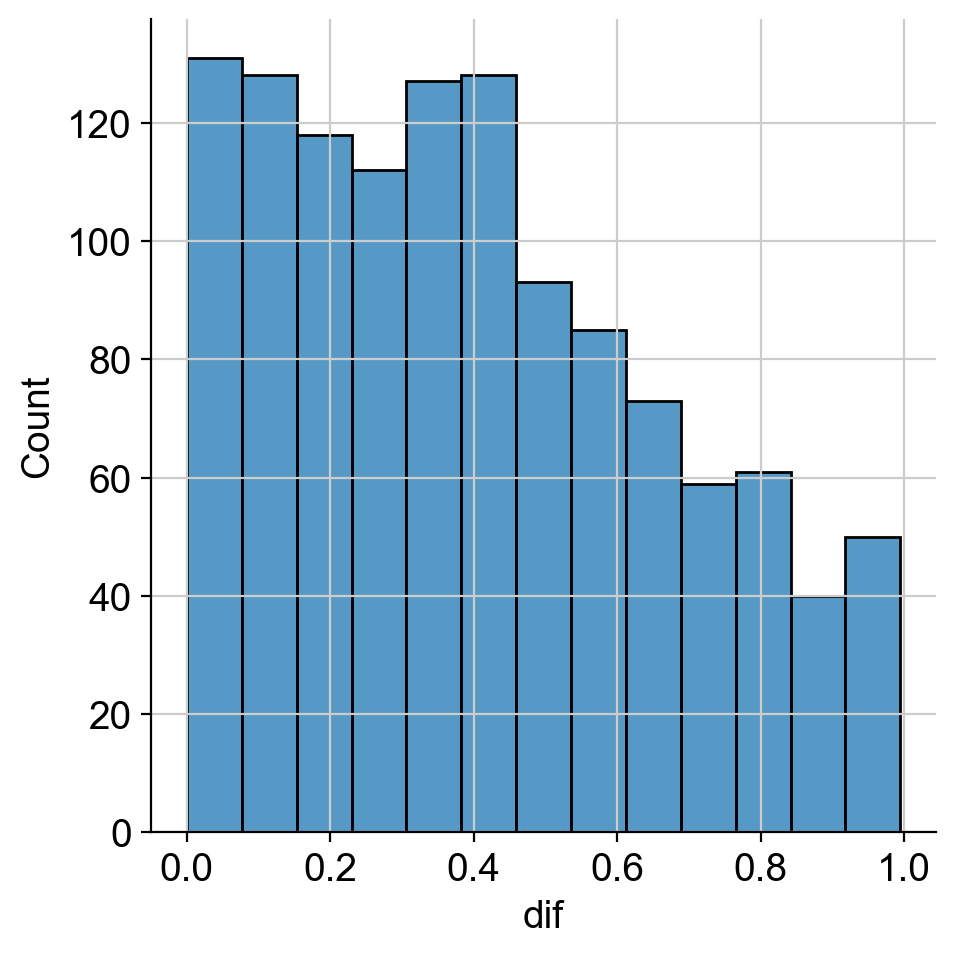

In [26]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [27]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 0.4)]
doublets

doublet   singlet prediction       dif
AAACGAACAGCGTGAA-1  0.725141  0.274859    doublet  0.450283
AAACGAAGTTAGGACG-1  0.820040  0.179960    doublet  0.640080
AAAGGGCAGTCGGGAT-1  0.801868  0.198132    doublet  0.603736
AAAGTCCTCGGCTGGT-1  0.710722  0.289278    doublet  0.421444
AACAAGATCAGCTAGT-1  0.782340  0.217660    doublet  0.564681
...                      ...       ...        ...       ...
TTTCCTCAGTCCTACA-1  0.898838  0.101162    doublet  0.797677
TTTCCTCCAGGAATCG-1  0.828591  0.171409    doublet  0.657183
TTTGATCCATTAAAGG-1  0.739398  0.260602    doublet  0.478796
TTTGATCGTACTAACC-1  0.726400  0.273600    doublet  0.452801
TTTGATCGTAGCTGTT-1  0.718890  0.281110    doublet  0.437779

[565 rows x 4 columns]

In [28]:
adata2

AnnData object with n_obs × n_vars = 4570 × 3000
    obs: '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'

In [29]:
# Define sample paths
sample_paths = {
    'V2': 'P:/Tolulope/Cellranger Results/Fry-Murach 4d OV aged/v2/outs/filtered_feature_bc_matrix',
    
}

# Load AnnData objects

adata2 = sc.read_10x_mtx(sample_paths['V2'])


In [30]:
adata2.obs

Empty DataFrame
Columns: []
Index: [AAACCCAGTGGGTCAA-1, AAACGAAAGAGAGAAC-1, AAACGAAAGTAGGAAG-1, AAACGAACAGAGATGC-1, AAACGAACAGCGTGAA-1, AAACGAAGTTAGGACG-1, AAACGAATCGGTCGAC-1, AAACGCTCACTCCACT-1, AAACGCTCAGCGTACC-1, AAACGCTGTACAAGTA-1, AAACGCTGTTGCCATA-1, AAACGCTTCCTGCTAC-1, AAAGAACAGTACCATC-1, AAAGAACCAAACGGCA-1, AAAGAACGTCGATGCC-1, AAAGAACTCGAACTCA-1, AAAGGATGTAGGCTGA-1, AAAGGATGTGTCATCA-1, AAAGGATGTGTCTTCC-1, AAAGGGCAGATCCAAA-1, AAAGGGCAGTCGGGAT-1, AAAGGGCCACCTCTAC-1, AAAGGGCGTACTGTTG-1, AAAGGGCGTCGAGCAA-1, AAAGGGCTCGTCAAAC-1, AAAGGTAAGGGCCCTT-1, AAAGGTAGTCGGTACC-1, AAAGGTAGTTAAGGAT-1, AAAGGTAGTTGCTCGG-1, AAAGGTAGTTGTGGAG-1, AAAGGTATCCCTCTAG-1, AAAGTCCAGCAAGGAA-1, AAAGTCCAGGTACCTT-1, AAAGTCCGTACAGAAT-1, AAAGTCCTCGCAGTCG-1, AAAGTCCTCGGCTGGT-1, AAAGTCCTCTCGACCT-1, AAAGTGAAGAATGTTG-1, AAAGTGAAGATACTGA-1, AAAGTGACATACATCG-1, AAAGTGACATCTGCGG-1, AAAGTGATCGGCCAAC-1, AAATGGAAGAGTTCGG-1, AAATGGACAGGGTCTC-1, AAATGGAGTATCCTTT-1, AAATGGATCTCAATCT-1, AAATGGATCTGACCCT-1, AACAAAGAGAAAGCGA-1, AACAAAGCATGACTCA-1, AACAACCCAAATACAG-1, AACAACCTCCCTGTTG-1, AACAACCTCGCCGATG-1, AACAAGAAGGCTTTCA-1, AACAAGAAGTCGGGAT-1, AACAAGAGTCTACAGT-1, AACAAGAGTGTCCGTG-1, AACAAGAGTTGGCCGT-1, AACAAGATCAGCTAGT-1, AACAAGATCGTTGCCT-1, AACAAGATCTGCCTGT-1, AACACACCACTTTAGG-1, AACACACCAGATCATC-1, AACACACCAGCGTGCT-1, AACACACGTACAACGG-1, AACACACGTGAATGAT-1, AACACACTCTCGCCTA-1, AACACACTCTGTAAGC-1, AACAGGGAGATTGATG-1, AACAGGGAGCGGATCA-1, AACAGGGAGGAGATAG-1, AACAGGGGTGGAATGC-1, AACAGGGTCAGTGTGT-1, AACCAACCACGCTGTG-1, AACCACAAGGCCATAG-1, AACCACACACCAGACC-1, AACCACACAGCCGTTG-1, AACCACACATAGGAGC-1, AACCACAGTATACGGG-1, AACCACATCAGACAAA-1, AACCATGCAACGACTT-1, AACCATGCAACGGCTC-1, AACCATGCACAAACGG-1, AACCATGGTCCTTAAG-1, AACCCAACAGCATACT-1, AACCTTTCAAACACCT-1, AACCTTTTCGACGATT-1, AACCTTTTCGTCCTCA-1, AACGAAAAGAAACCAT-1, AACGAAAAGAAATCCA-1, AACGAAAAGTCGCTAT-1, AACGAAACACAATGTC-1, AACGAAACACCGAATT-1, AACGAAAGTATCGAGG-1, AACGAAAGTCTGTGGC-1, AACGGGACATGGATCT-1, AACGGGAGTGAGGCAT-1, AACGGGAGTGATACTC-1, AACGTCACATATGAAG-1, AACGTCACATGACTTG-1, AACGTCAGTCCTTTGC-1, ...]

[4570 rows x 0 columns]

In [31]:
adata2.obs['doublet'] = adata2.obs.index.isin(doublets.index) 

In [32]:
adata2.obs

doublet
AAACCCAGTGGGTCAA-1    False
AAACGAAAGAGAGAAC-1    False
AAACGAAAGTAGGAAG-1    False
AAACGAACAGAGATGC-1    False
AAACGAACAGCGTGAA-1     True
...                     ...
TTTGGTTGTGTGACCC-1    False
TTTGTTGGTACAGAAT-1    False
TTTGTTGGTTAGCGGA-1    False
TTTGTTGTCATCGACA-1    False
TTTGTTGTCTATCCAT-1    False

[4570 rows x 1 columns]

In [33]:
adata2 = adata2[~adata2.obs.doublet]
adata2

View of AnnData object with n_obs × n_vars = 4005 × 41464
    obs: 'doublet'
    var: 'gene_ids', 'feature_types'

In [34]:
#sample3
adata3

AnnData object with n_obs × n_vars = 4736 × 41464
    var: 'gene_ids', 'feature_types'

In [35]:
sc.pp.filter_genes(adata3, min_cells = 10)
sc.pp.highly_variable_genes(adata3, n_top_genes = 3000, subset = True, flavor = 'seurat_v3')

In [36]:
scvi.model.SCVI.setup_anndata(adata3)
vae = scvi.model.SCVI(adata3)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████| 400/400 [06:27<00:00,  1.04it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.33e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████| 400/400 [06:27<00:00,  1.03it/s, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.33e+3]


In [37]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█████████| 400/400 [01:30<00:00,  4.51it/s, v_num=1, train_loss_step=0.303, train_loss_epoch=0.307]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████| 400/400 [01:30<00:00,  4.40it/s, v_num=1, train_loss_step=0.303, train_loss_epoch=0.307]


In [38]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df

doublet   singlet prediction
AAACCCAAGGTGCCAA-1  0.386059  0.613941    singlet
AAACCCATCTACTGCC-1  0.273316  0.726684    singlet
AAACCCATCTCCATAT-1  0.934182  0.065818    doublet
AAACGAACACATGGTT-1  0.198736  0.801264    singlet
AAACGAACAGATCCAT-1  0.200495  0.799505    singlet
...                      ...       ...        ...
TTTGTTGAGTGTTCCA-1  0.023687  0.976314    singlet
TTTGTTGCAAAGGCAC-1  0.136897  0.863103    singlet
TTTGTTGCAGTCACGC-1  0.313868  0.686132    singlet
TTTGTTGCATATCTCT-1  0.551452  0.448548    doublet
TTTGTTGTCTAGTTCT-1  0.190655  0.809345    singlet

[4736 rows x 3 columns]

In [39]:
df.groupby('prediction').count()

doublet  singlet
prediction                  
doublet         676      676
singlet        4060     4060

In [40]:
df['dif'] = df.doublet - df.singlet
df

doublet   singlet prediction       dif
AAACCCAAGGTGCCAA-1  0.386059  0.613941    singlet -0.227883
AAACCCATCTACTGCC-1  0.273316  0.726684    singlet -0.453369
AAACCCATCTCCATAT-1  0.934182  0.065818    doublet  0.868364
AAACGAACACATGGTT-1  0.198736  0.801264    singlet -0.602527
AAACGAACAGATCCAT-1  0.200495  0.799505    singlet -0.599011
...                      ...       ...        ...       ...
TTTGTTGAGTGTTCCA-1  0.023687  0.976314    singlet -0.952627
TTTGTTGCAAAGGCAC-1  0.136897  0.863103    singlet -0.726207
TTTGTTGCAGTCACGC-1  0.313868  0.686132    singlet -0.372265
TTTGTTGCATATCTCT-1  0.551452  0.448548    doublet  0.102903
TTTGTTGTCTAGTTCT-1  0.190655  0.809345    singlet -0.618690

[4736 rows x 4 columns]

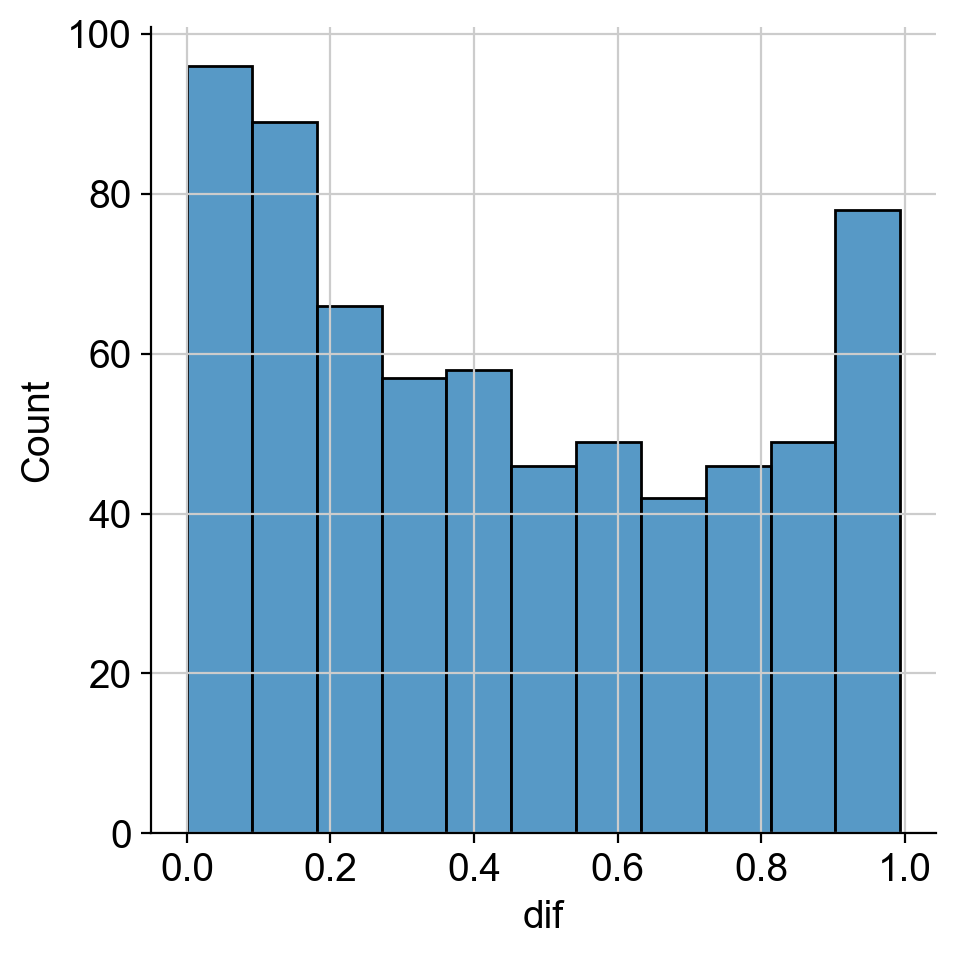

In [41]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [42]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 0.4)]
doublets

doublet   singlet prediction       dif
AAACCCATCTCCATAT-1  0.934182  0.065818    doublet  0.868364
AAAGAACAGCAGCGAT-1  0.833183  0.166817    doublet  0.666366
AAAGGGCTCACACCCT-1  0.889239  0.110761    doublet  0.778479
AAAGGTATCCACTTCG-1  0.965996  0.034004    doublet  0.931992
AACAAGACAAGGCTTT-1  0.737950  0.262050    doublet  0.475901
...                      ...       ...        ...       ...
TTGGGCGGTAGCTGAG-1  0.772807  0.227193    doublet  0.545615
TTGGTTTAGTTAGTGA-1  0.991370  0.008630    doublet  0.982739
TTTACGTAGCAGTAAT-1  0.708120  0.291880    doublet  0.416240
TTTCACAAGATGAACT-1  0.765233  0.234767    doublet  0.530466
TTTCACACAGATTTCG-1  0.839262  0.160738    doublet  0.678524

[336 rows x 4 columns]

In [43]:
adata3

AnnData object with n_obs × n_vars = 4736 × 3000
    obs: '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'

In [44]:
# Define sample paths
sample_paths = {
    'T1': 'P:/Tolulope/Cellranger Results/Fry-Murach 4d OV aged/t1/outs/filtered_feature_bc_matrix',
   
}

# Load AnnData objects

adata3 = sc.read_10x_mtx(sample_paths['T1'])


In [45]:
adata3.obs

Empty DataFrame
Columns: []
Index: [AAACCCAAGGTGCCAA-1, AAACCCATCTACTGCC-1, AAACCCATCTCCATAT-1, AAACGAACACATGGTT-1, AAACGAACAGATCCAT-1, AAACGAACATCCCACT-1, AAACGAAGTAGCTCGC-1, AAACGAAGTGCCTACG-1, AAACGAATCCGAACGC-1, AAACGAATCTAACGGT-1, AAACGCTAGCTGGCTC-1, AAACGCTAGGCTAACG-1, AAACGCTAGGTTAAAC-1, AAACGCTCACCAAATC-1, AAACGCTGTGCCAAGA-1, AAACGCTGTTCTCGCT-1, AAACGCTTCGTAGCTA-1, AAACGCTTCTACTATC-1, AAACGCTTCTATCGGA-1, AAAGAACAGCAGCGAT-1, AAAGAACAGGGTCACA-1, AAAGAACCAATTTCCT-1, AAAGAACTCCGAGATT-1, AAAGGATAGGAAGAAC-1, AAAGGATCATGGACAG-1, AAAGGATTCTCCTGCA-1, AAAGGGCAGAGGCGGA-1, AAAGGGCAGGCTAACG-1, AAAGGGCGTCTGTCCT-1, AAAGGGCTCACACCCT-1, AAAGGTACAAGCACCC-1, AAAGGTACACTAAACC-1, AAAGGTAGTACTCCCT-1, AAAGGTAGTTGCGGCT-1, AAAGGTATCCACTTCG-1, AAAGGTATCGGACGTC-1, AAAGTCCAGTTCGCAT-1, AAAGTCCCATACGCAT-1, AAAGTCCGTTCCACGG-1, AAAGTCCTCAGACTGT-1, AAAGTCCTCTCTGACC-1, AAAGTGACATGGCACC-1, AAAGTGAGTGTTCGAT-1, AAAGTGATCCATTTGT-1, AAATGGAAGCCATGCC-1, AAATGGAAGCTACAAA-1, AAATGGAGTGTAGCAG-1, AAATGGAGTTCCGCAG-1, AACAAAGAGTACAGCG-1, AACAAAGCATTATGCG-1, AACAAAGGTGTCCAAT-1, AACAAAGGTGTGGTCC-1, AACAAAGTCCCATACC-1, AACAACCAGGTCCCGT-1, AACAACCAGTGACACG-1, AACAACCCACAATTCG-1, AACAACCCACGGCTAC-1, AACAACCCACTGGAAG-1, AACAACCCATAAGCGG-1, AACAAGAAGTAGTCAA-1, AACAAGACAAGGCTTT-1, AACAAGAGTCGACTGC-1, AACACACAGCATGCAG-1, AACACACCACATTACG-1, AACACACGTAACACCT-1, AACACACTCAGTCCGG-1, AACACACTCATGCGGC-1, AACACACTCTGCGGCA-1, AACAGGGAGATGACAT-1, AACAGGGAGTGGTTAA-1, AACAGGGCAAGAGAGA-1, AACAGGGCAGCCGTTG-1, AACAGGGGTGGTCTTA-1, AACAGGGTCATTTCGT-1, AACAGGGTCGCTGTCT-1, AACAGGGTCGGAGTAG-1, AACAGGGTCGTTAGAC-1, AACCAACAGCGAGAAA-1, AACCAACCACTGTCGG-1, AACCAACCAGTTACCA-1, AACCAACGTGGTGATG-1, AACCAACTCCGTCACT-1, AACCAACTCGTCTCAC-1, AACCACACAAACGTGG-1, AACCACACAACAACAA-1, AACCACACAGACCTGC-1, AACCACAGTGCACAAG-1, AACCACAGTGCCTGAC-1, AACCATGAGTCTTCCC-1, AACCATGCACCATATG-1, AACCATGCAGGCACTC-1, AACCATGGTCGAGCAA-1, AACCCAAAGTCATCGT-1, AACCCAAGTATAGGAT-1, AACCCAAGTGCCCTTT-1, AACCCAATCATTACCT-1, AACCTGACACTATCCC-1, AACCTGACAGAGGCTA-1, AACCTGATCTAGGCAT-1, AACCTTTAGCTGAGCA-1, ...]

[4736 rows x 0 columns]

In [46]:
adata3.obs['doublet'] = adata3.obs.index.isin(doublets.index) 

In [47]:
adata3.obs

doublet
AAACCCAAGGTGCCAA-1    False
AAACCCATCTACTGCC-1    False
AAACCCATCTCCATAT-1     True
AAACGAACACATGGTT-1    False
AAACGAACAGATCCAT-1    False
...                     ...
TTTGTTGAGTGTTCCA-1    False
TTTGTTGCAAAGGCAC-1    False
TTTGTTGCAGTCACGC-1    False
TTTGTTGCATATCTCT-1    False
TTTGTTGTCTAGTTCT-1    False

[4736 rows x 1 columns]

In [48]:
adata3 = adata3[~adata3.obs.doublet]
adata3

View of AnnData object with n_obs × n_vars = 4400 × 41464
    obs: 'doublet'
    var: 'gene_ids', 'feature_types'

In [49]:
#sample4
adata4

AnnData object with n_obs × n_vars = 4890 × 41464
    var: 'gene_ids', 'feature_types'

In [50]:
sc.pp.filter_genes(adata4, min_cells = 10)
sc.pp.highly_variable_genes(adata4, n_top_genes = 3000, subset = True, flavor = 'seurat_v3')

In [51]:
scvi.model.SCVI.setup_anndata(adata4)
vae = scvi.model.SCVI(adata4)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█████| 400/400 [06:29<00:00,  1.03it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.14e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [06:29<00:00,  1.03it/s, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.14e+3]


In [52]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 338/400:  84%|████████▍ | 338/400 [01:21<00:14,  4.16it/s, v_num=1, train_loss_step=0.361, train_loss_epoch=0.32]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.299. Signaling Trainer to stop.


In [53]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df

doublet   singlet prediction
AAACCCACACTGTCCT-1  0.437864  0.562136    singlet
AAACCCACATACCACA-1  0.140520  0.859480    singlet
AAACCCAGTACCACGC-1  0.620074  0.379926    doublet
AAACCCATCAGACCCG-1  0.322593  0.677407    singlet
AAACCCATCGGCATTA-1  0.215185  0.784815    singlet
...                      ...       ...        ...
TTTGTTGAGGCCACTC-1  0.200502  0.799498    singlet
TTTGTTGCAAGTGGCA-1  0.415471  0.584529    singlet
TTTGTTGGTCCATAGT-1  0.033350  0.966650    singlet
TTTGTTGTCCGCATAA-1  0.024308  0.975692    singlet
TTTGTTGTCTGAGATC-1  0.214489  0.785511    singlet

[4890 rows x 3 columns]

In [54]:
df.groupby('prediction').count()

doublet  singlet
prediction                  
doublet         903      903
singlet        3987     3987

In [55]:
df['dif'] = df.doublet - df.singlet
df

doublet   singlet prediction       dif
AAACCCACACTGTCCT-1  0.437864  0.562136    singlet -0.124272
AAACCCACATACCACA-1  0.140520  0.859480    singlet -0.718959
AAACCCAGTACCACGC-1  0.620074  0.379926    doublet  0.240147
AAACCCATCAGACCCG-1  0.322593  0.677407    singlet -0.354814
AAACCCATCGGCATTA-1  0.215185  0.784815    singlet -0.569630
...                      ...       ...        ...       ...
TTTGTTGAGGCCACTC-1  0.200502  0.799498    singlet -0.598996
TTTGTTGCAAGTGGCA-1  0.415471  0.584529    singlet -0.169059
TTTGTTGGTCCATAGT-1  0.033350  0.966650    singlet -0.933299
TTTGTTGTCCGCATAA-1  0.024308  0.975692    singlet -0.951385
TTTGTTGTCTGAGATC-1  0.214489  0.785511    singlet -0.571022

[4890 rows x 4 columns]

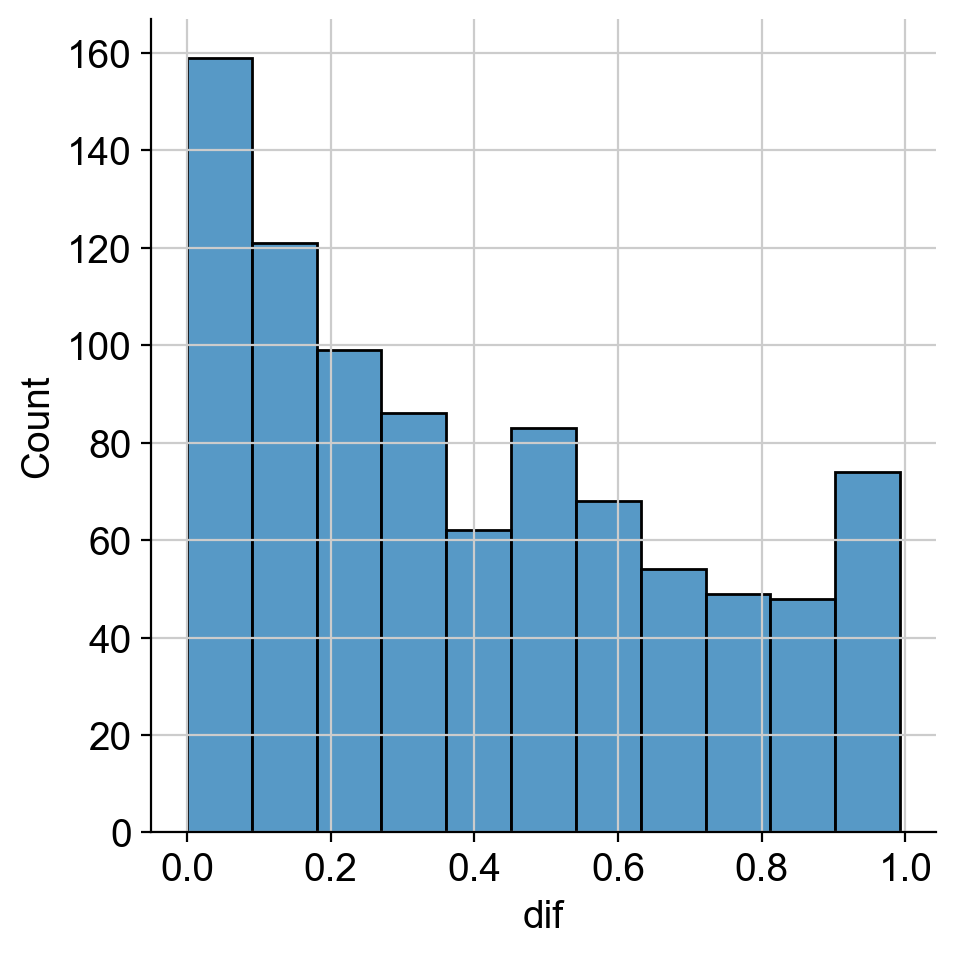

In [56]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [57]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 0.4)]
doublets

doublet   singlet prediction       dif
AAAGGTATCCTCATAT-1  0.978581  0.021418    doublet  0.957163
AAAGTCCCAAGAGCTG-1  0.719027  0.280973    doublet  0.438055
AACAAGAGTAACTAAG-1  0.946028  0.053972    doublet  0.892056
AACACACTCGCTCCTA-1  0.871483  0.128517    doublet  0.742966
AACAGGGAGGGCAGAG-1  0.915738  0.084262    doublet  0.831477
...                      ...       ...        ...       ...
TTTCAGTAGACGGTTG-1  0.754384  0.245616    doublet  0.508767
TTTGACTGTGCAACAG-1  0.703313  0.296687    doublet  0.406625
TTTGATCTCGGACAAG-1  0.923844  0.076156    doublet  0.847688
TTTGGTTGTAGCACGA-1  0.936424  0.063576    doublet  0.872849
TTTGGTTGTAGGAGTC-1  0.759520  0.240480    doublet  0.519039

[406 rows x 4 columns]

In [58]:
adata4

AnnData object with n_obs × n_vars = 4890 × 3000
    obs: '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'

In [59]:
# Define sample paths
sample_paths = {
    'T2': 'P:/Tolulope/Cellranger Results/Fry-Murach 4d OV aged/t2/outs/filtered_feature_bc_matrix'
}

# Load AnnData objects

adata4 = sc.read_10x_mtx(sample_paths['T2'])

In [60]:
adata4.obs

Empty DataFrame
Columns: []
Index: [AAACCCACACTGTCCT-1, AAACCCACATACCACA-1, AAACCCAGTACCACGC-1, AAACCCATCAGACCCG-1, AAACCCATCGGCATTA-1, AAACCCATCTATCGTT-1, AAACGAAAGCACAAAT-1, AAACGAAAGGTCGTCC-1, AAACGAACAACTCATG-1, AAACGAACACTAACGT-1, AAACGAACAGTCTCTC-1, AAACGAAGTCGCACGT-1, AAACGAAGTCGTTCAA-1, AAACGAAGTTCCAGGC-1, AAACGAATCACTACGA-1, AAACGAATCCTGTTAT-1, AAACGAATCTCAGTCC-1, AAACGCTAGCGCTTCG-1, AAACGCTAGGAAAGGT-1, AAACGCTAGTAGGCCA-1, AAACGCTCAACCCTAA-1, AAACGCTCACGGTGCT-1, AAACGCTTCATCCTGC-1, AAACGCTTCCTGCCAT-1, AAACGCTTCTGCCCTA-1, AAAGAACAGGCTCACC-1, AAAGAACAGTCTGGTT-1, AAAGAACCAACCAACT-1, AAAGGATCATATCTGG-1, AAAGGATCATCAGTCA-1, AAAGGATGTAACGATA-1, AAAGGATGTGACATCT-1, AAAGGATTCCGGACTG-1, AAAGGGCCAACGGCCT-1, AAAGGGCCAATTCACG-1, AAAGGGCGTTCTCTCG-1, AAAGGGCTCAGAACCT-1, AAAGGGCTCTGTAAGC-1, AAAGGGCTCTTCTTCC-1, AAAGGTAAGATAGCAT-1, AAAGGTAAGGATATAC-1, AAAGGTAAGTATTAGG-1, AAAGGTACATACAGGG-1, AAAGGTAGTGGTCTGC-1, AAAGGTATCCTCATAT-1, AAAGTCCAGGATCATA-1, AAAGTCCCAAAGAACT-1, AAAGTCCCAAGAGCTG-1, AAAGTCCCAAGCTGCC-1, AAAGTCCGTGCCCACA-1, AAAGTCCTCCAAGCTA-1, AAAGTCCTCTTGCAGA-1, AAAGTGAAGACAACTA-1, AAAGTGAAGATGGGCT-1, AAAGTGACAAAGCAAT-1, AAAGTGACAATGTCTG-1, AAAGTGACACACGTGC-1, AAAGTGACATGCAGGA-1, AAAGTGATCCATAAGC-1, AAATGGAAGACAACAT-1, AAATGGAAGGAGCAAA-1, AAATGGAAGGTTTGAA-1, AACAAAGCAATATCCG-1, AACAAAGCACCTGAAT-1, AACAAAGGTTCCATTT-1, AACAACCCAAATCGGG-1, AACAACCCACATTCTT-1, AACAACCCACTCAAGT-1, AACAACCCATCACCAA-1, AACAACCTCTAGCCAA-1, AACAAGAAGAATCGTA-1, AACAAGAAGGCGTTAG-1, AACAAGAAGTTGCGCC-1, AACAAGACAACTCATG-1, AACAAGAGTAACTAAG-1, AACAAGAGTACGTGTT-1, AACAAGAGTATCGGTT-1, AACAAGATCTGCGAGC-1, AACACACGTCACCCTT-1, AACACACTCAGGAACG-1, AACACACTCCACATAG-1, AACACACTCGCTCCTA-1, AACAGGGAGAATCGTA-1, AACAGGGAGCAACAGC-1, AACAGGGAGCTAATCC-1, AACAGGGAGGGCAGAG-1, AACAGGGCAGACCAGA-1, AACAGGGCAGCTGAAG-1, AACAGGGGTGATACAA-1, AACCAACCAGCACAAG-1, AACCAACGTAGGCAGT-1, AACCAACGTGCTATTG-1, AACCAACGTTCCGGTG-1, AACCAACGTTGTAAAG-1, AACCAACTCCACGTAA-1, AACCACAAGACCAACG-1, AACCACACAACCTAAC-1, AACCACACACCAGGTC-1, AACCACATCGGTCTAA-1, AACCATGAGGCTTCCG-1, ...]

[4890 rows x 0 columns]

In [61]:
adata4.obs['doublet'] = adata4.obs.index.isin(doublets.index) 

In [62]:
adata4.obs

doublet
AAACCCACACTGTCCT-1    False
AAACCCACATACCACA-1    False
AAACCCAGTACCACGC-1    False
AAACCCATCAGACCCG-1    False
AAACCCATCGGCATTA-1    False
...                     ...
TTTGTTGAGGCCACTC-1    False
TTTGTTGCAAGTGGCA-1    False
TTTGTTGGTCCATAGT-1    False
TTTGTTGTCCGCATAA-1    False
TTTGTTGTCTGAGATC-1    False

[4890 rows x 1 columns]

In [63]:
adata4 = adata4[~adata4.obs.doublet]
adata4

View of AnnData object with n_obs × n_vars = 4484 × 41464
    obs: 'doublet'
    var: 'gene_ids', 'feature_types'

In [64]:
# Make variable names unique
for adata in [adata1, adata2, adata3, adata4]:
    adata.var_names_make_unique()
    adata.raw = adata

In [65]:
# Quality Control (QC)
for adata in [adata1, adata2, adata3, adata4]:
    sc.pp.filter_cells(adata, min_genes=200)#get rid of cells with fewer than 200 genes

In [66]:
# Annotate mitochondrial genes
for adata in [adata1, adata2, adata3, adata4]:
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # Assuming mitochondrial genes start with 'MT-'

In [67]:
adata4.var[adata4.var.mt == True]

gene_ids    feature_types    mt
mt-Rnr1  mt-Rnr1  Gene Expression  True
mt-Rnr2  mt-Rnr2  Gene Expression  True

In [68]:
# Annotate ribosomal genes
for adata in [adata1, adata2, adata3, adata4]:
    adata.var['ribo'] = adata.var_names.str.startswith(('Rps', 'Rpl'))

In [69]:
adata4.var[adata4.var['ribo']]

gene_ids    feature_types     mt  ribo
Rps2-ps2      Rps2-ps2  Gene Expression  False  True
Rpl5-ps1      Rpl5-ps1  Gene Expression  False  True
Rpl7              Rpl7  Gene Expression  False  True
Rpl12-ps1    Rpl12-ps1  Gene Expression  False  True
Rpl31            Rpl31  Gene Expression  False  True
...                ...              ...    ...   ...
Rps12-ps13  Rps12-ps13  Gene Expression  False  True
Rps12-ps14  Rps12-ps14  Gene Expression  False  True
Rps12-ps16  Rps12-ps16  Gene Expression  False  True
Rpl36a          Rpl36a  Gene Expression  False  True
Rps6ka3        Rps6ka3  Gene Expression  False  True

[143 rows x 4 columns]

In [70]:
# Annotate ribosomal genes
for adata in [adata1, adata2, adata3, adata4]:
    adata.var['hb'] = adata.var_names.str.contains('^Hb[^(P)]', regex=True)

In [71]:
adata4.var[adata4.var['hb']]

gene_ids    feature_types     mt   ribo    hb
Hbb-bt    Hbb-bt  Gene Expression  False  False  True
Hbb-bs    Hbb-bs  Gene Expression  False  False  True
Hbb-bh2  Hbb-bh2  Gene Expression  False  False  True
Hbb-bh1  Hbb-bh1  Gene Expression  False  False  True
Hbb-y      Hbb-y  Gene Expression  False  False  True
Hbs1l      Hbs1l  Gene Expression  False  False  True
Hba-x      Hba-x  Gene Expression  False  False  True
Hba-a1    Hba-a1  Gene Expression  False  False  True
Hbq1b      Hbq1b  Gene Expression  False  False  True
Hba-a2    Hba-a2  Gene Expression  False  False  True
Hbq1a      Hbq1a  Gene Expression  False  False  True
Hbp1        Hbp1  Gene Expression  False  False  True
Hbegf      Hbegf  Gene Expression  False  False  True

In [72]:
adata1

AnnData object with n_obs × n_vars = 4564 × 41464
    obs: 'doublet', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb'

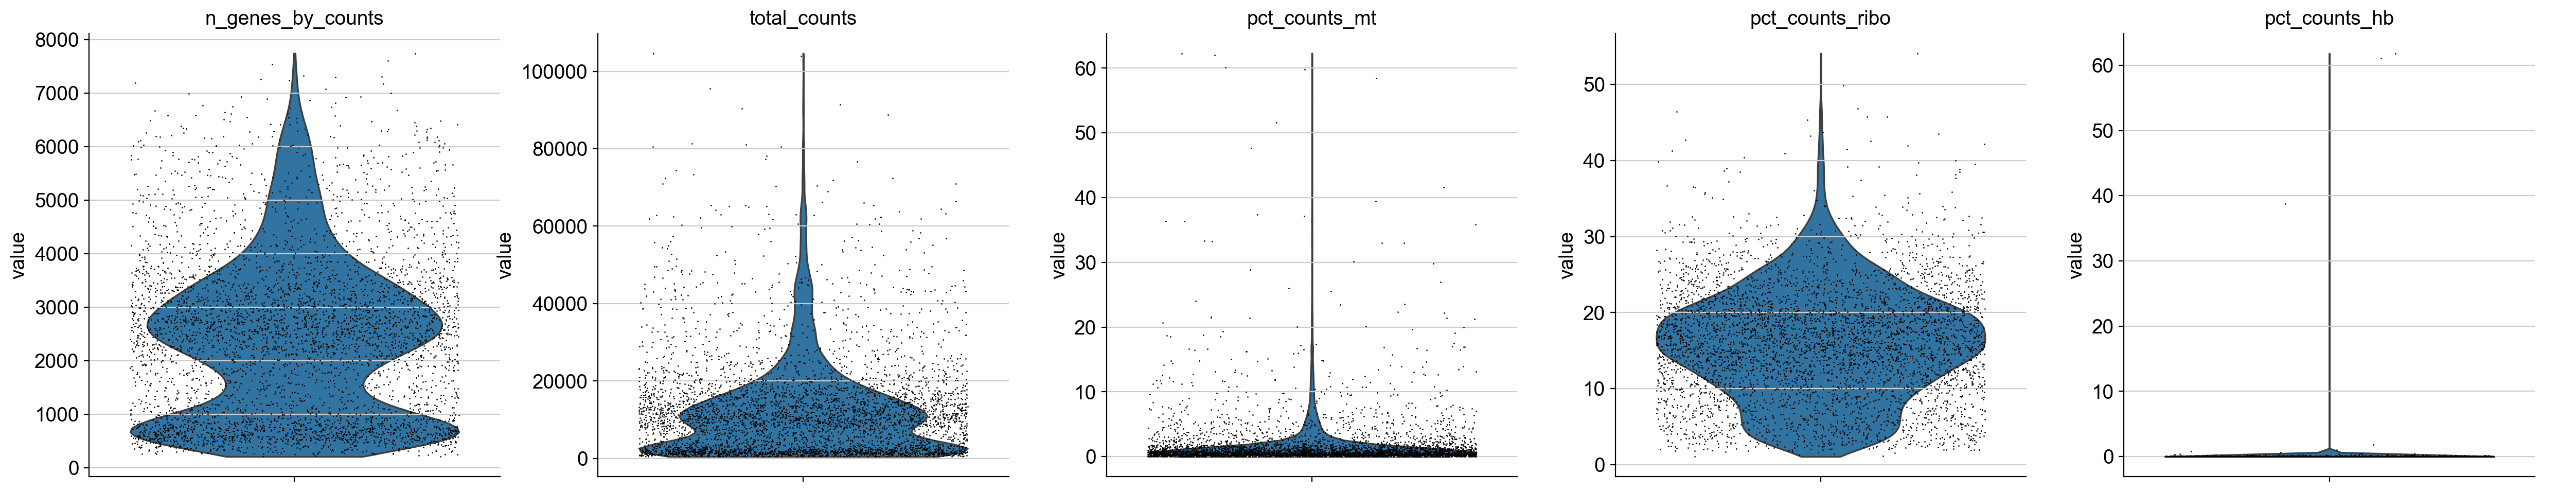

In [73]:
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata1, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo','pct_counts_hb'],
             jitter=0.4, multi_panel=True)

In [74]:
#instead of picking subjectively, you can use quanitle
upper_lim = np.quantile(adata1.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata1.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

371.78000000000003 to 6023.959999999999


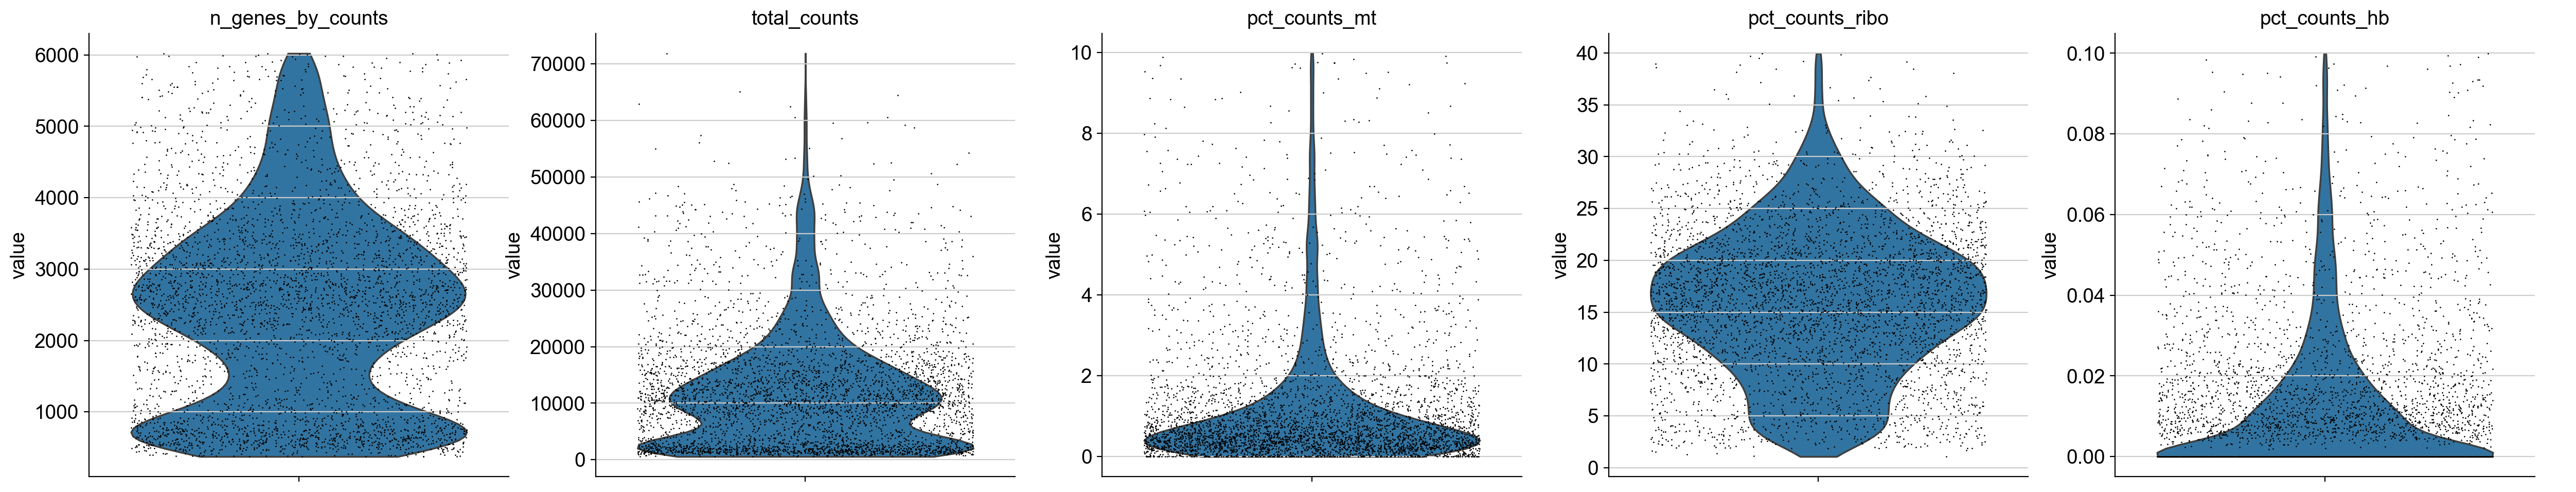

In [75]:
adata1 = adata1[(adata1.obs.n_genes_by_counts < upper_lim) & (adata1.obs.n_genes_by_counts > lower_lim)]
adata1 = adata1[adata1.obs.pct_counts_mt < 10]
adata1 = adata1[adata1.obs.pct_counts_ribo < 40]
adata1 = adata1[adata1.obs['pct_counts_hb'] < 0.1].copy()

sc.pl.violin(adata1, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, multi_panel=True)

In [76]:
adata1

AnnData object with n_obs × n_vars = 4150 × 41464
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

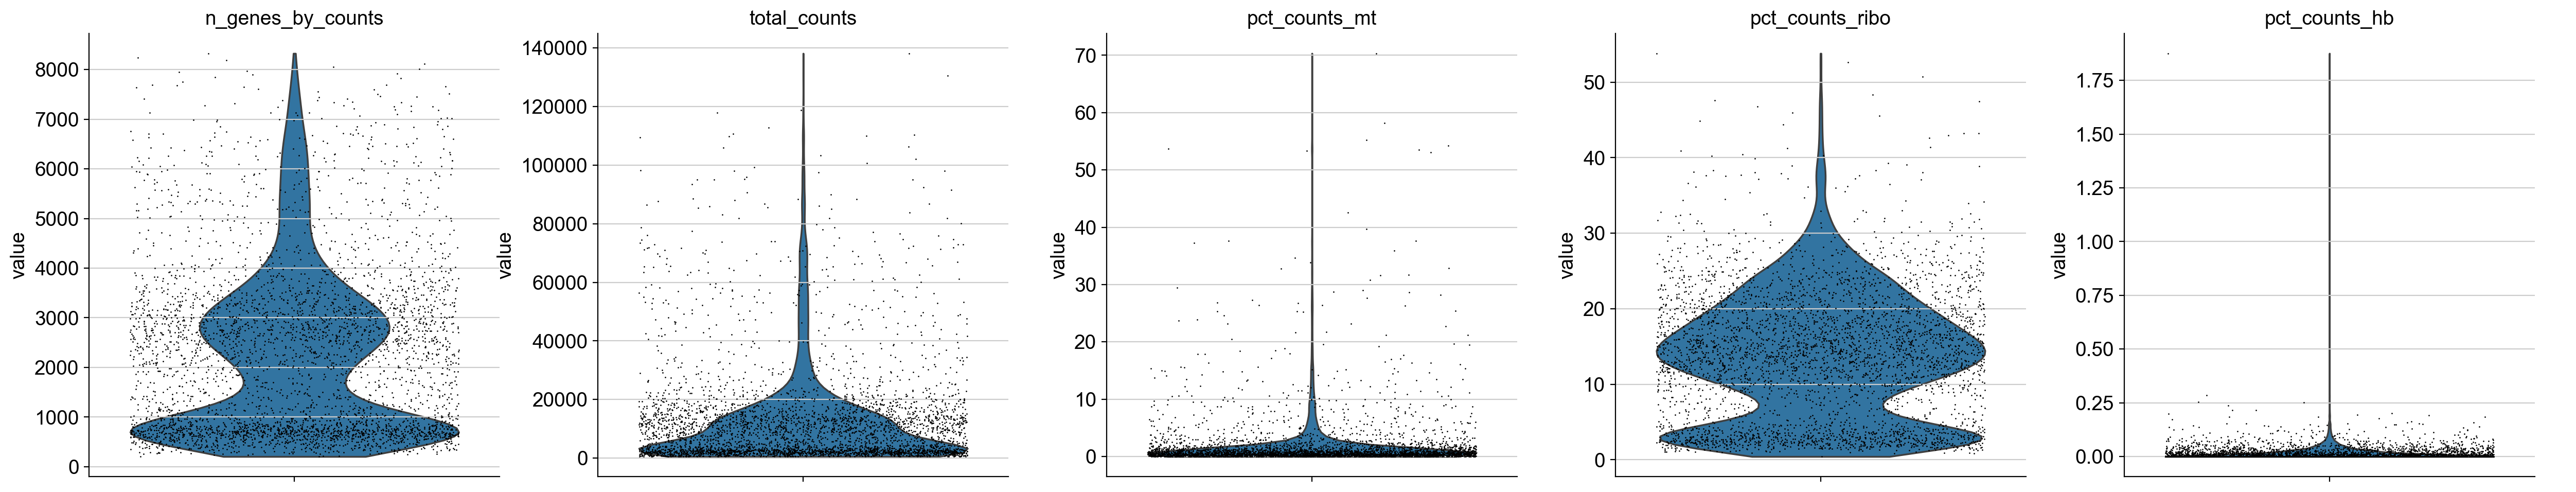

In [77]:
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo','pct_counts_hb'],
             jitter=0.4, multi_panel=True)

In [78]:
#instead of picking subjectively, you can use quanitle
upper_lim = np.quantile(adata2.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata2.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

349.94 to 6707.0


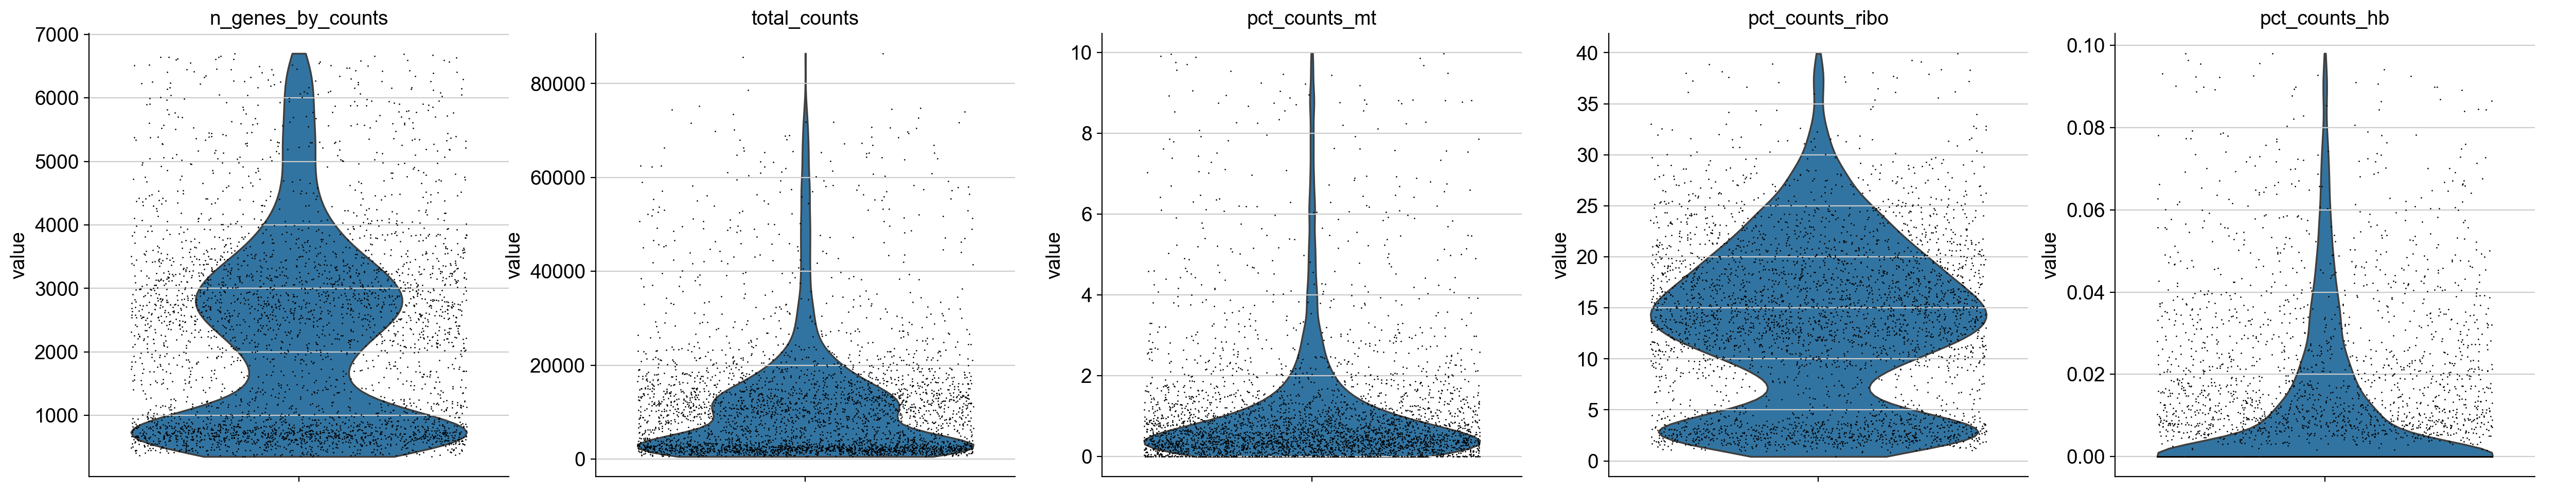

In [79]:
adata2 = adata2[(adata2.obs.n_genes_by_counts < upper_lim) & (adata2.obs.n_genes_by_counts > lower_lim)]
adata2 = adata2[adata2.obs.pct_counts_mt < 10]
adata2 = adata2[adata2.obs.pct_counts_ribo < 40]
adata2 = adata2[adata2.obs['pct_counts_hb'] < 0.1].copy()

sc.pl.violin(adata2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, multi_panel=True)

In [80]:
adata2

AnnData object with n_obs × n_vars = 3638 × 41464
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

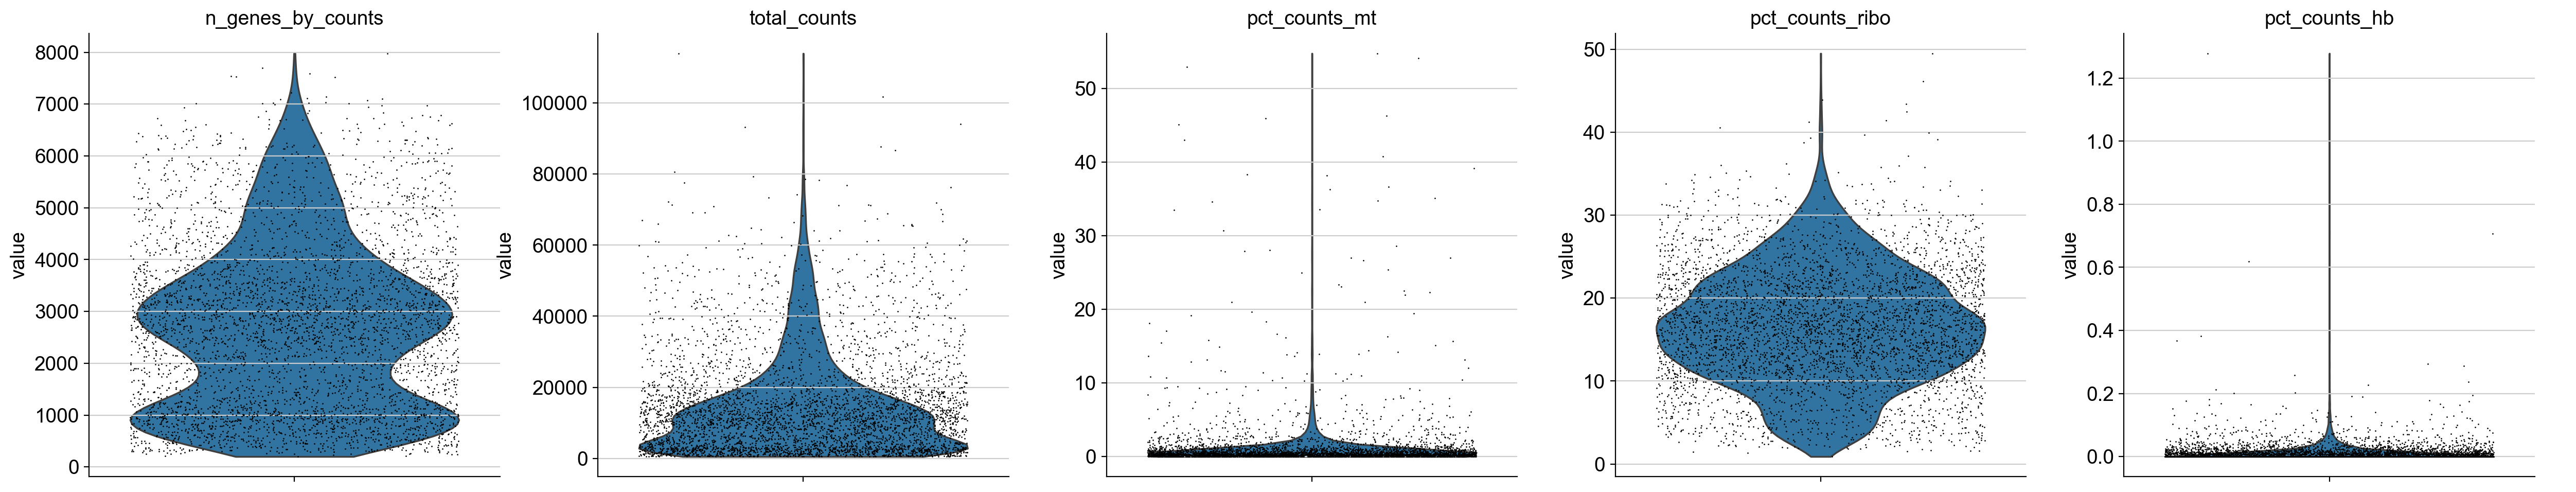

In [81]:
sc.pp.calculate_qc_metrics(adata3, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata3, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo','pct_counts_hb'],
             jitter=0.4, multi_panel=True)

In [82]:
#instead of picking subjectively, you can use quanitle
upper_lim = np.quantile(adata3.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata3.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

366.84000000000003 to 6293.48


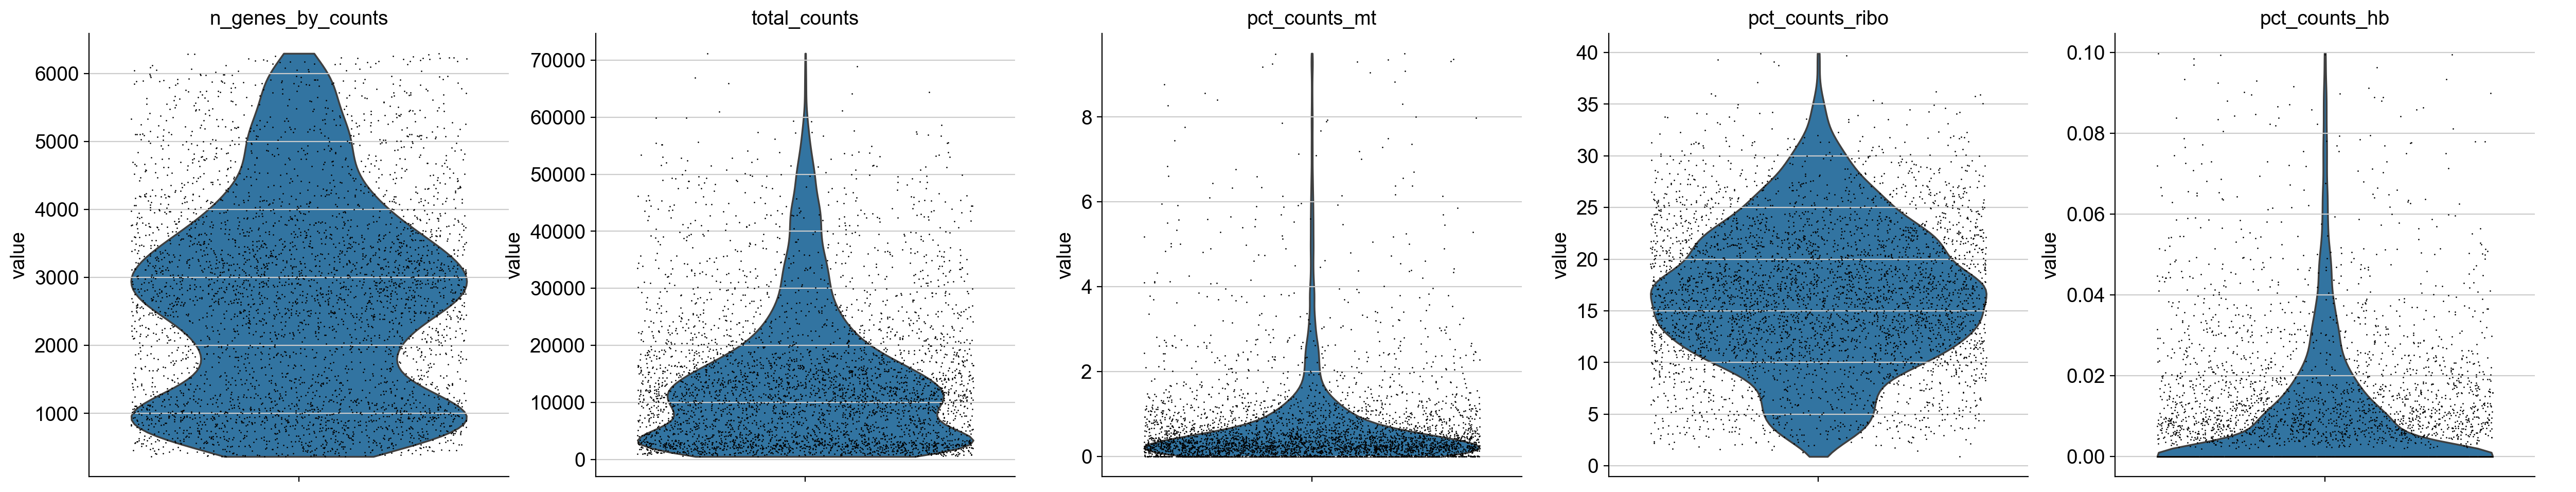

In [83]:
adata3 = adata3[(adata3.obs.n_genes_by_counts < upper_lim) & (adata3.obs.n_genes_by_counts > lower_lim)]
adata3 = adata3[adata3.obs.pct_counts_mt < 10]
adata3 = adata3[adata3.obs.pct_counts_ribo < 40]
adata3 = adata3[adata3.obs['pct_counts_hb'] < 0.1].copy()

sc.pl.violin(adata3, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, multi_panel=True)

In [84]:
adata3

AnnData object with n_obs × n_vars = 4096 × 41464
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

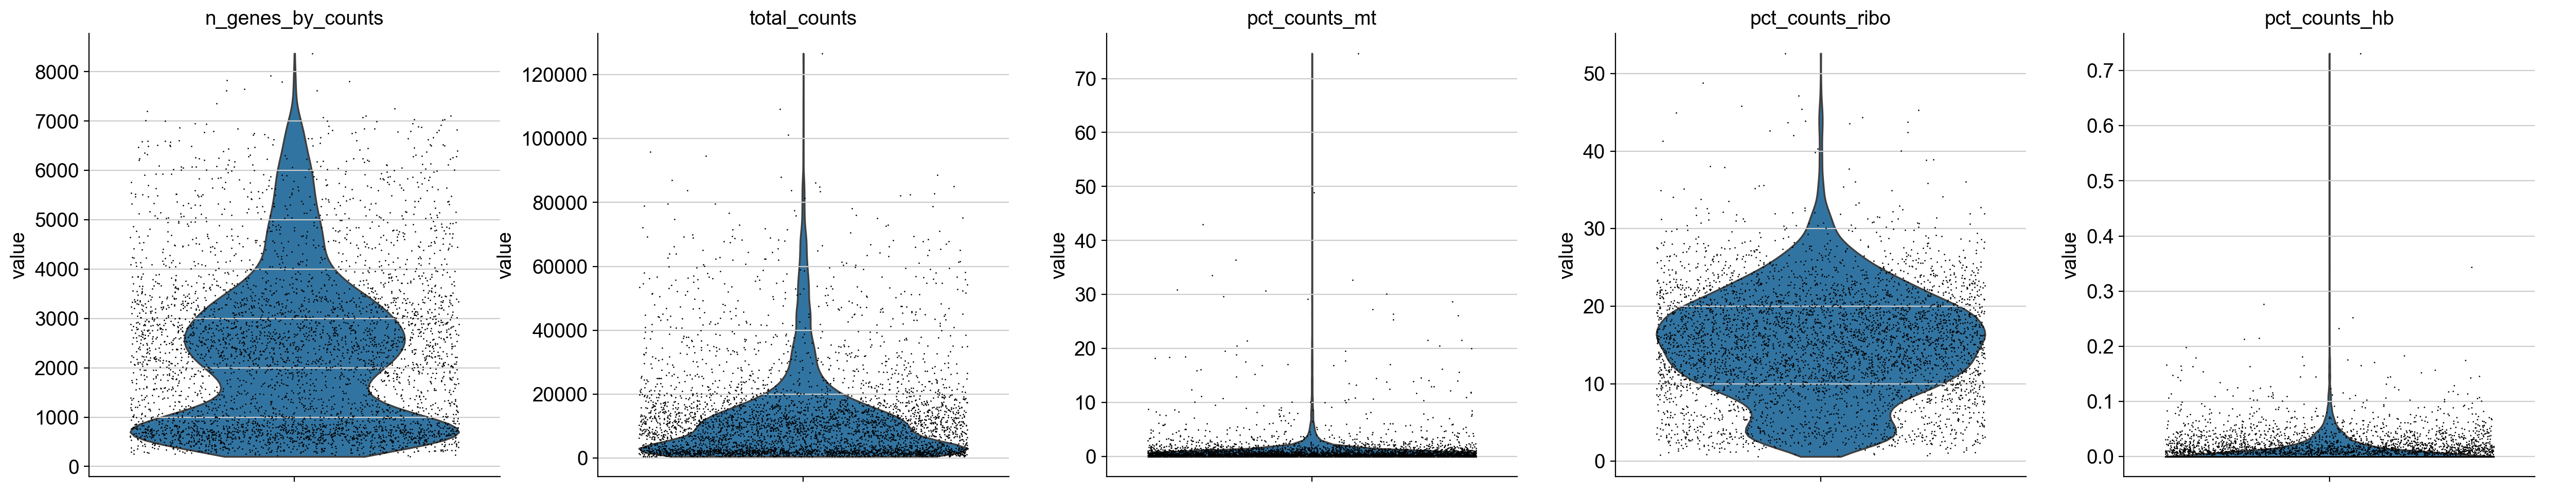

In [85]:
sc.pp.calculate_qc_metrics(adata4, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata4, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo','pct_counts_hb'],
             jitter=0.4, multi_panel=True)

In [86]:
#instead of picking subjectively, you can use quanitle
upper_lim = np.quantile(adata4.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata4.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

333.58 to 6284.9400000000005


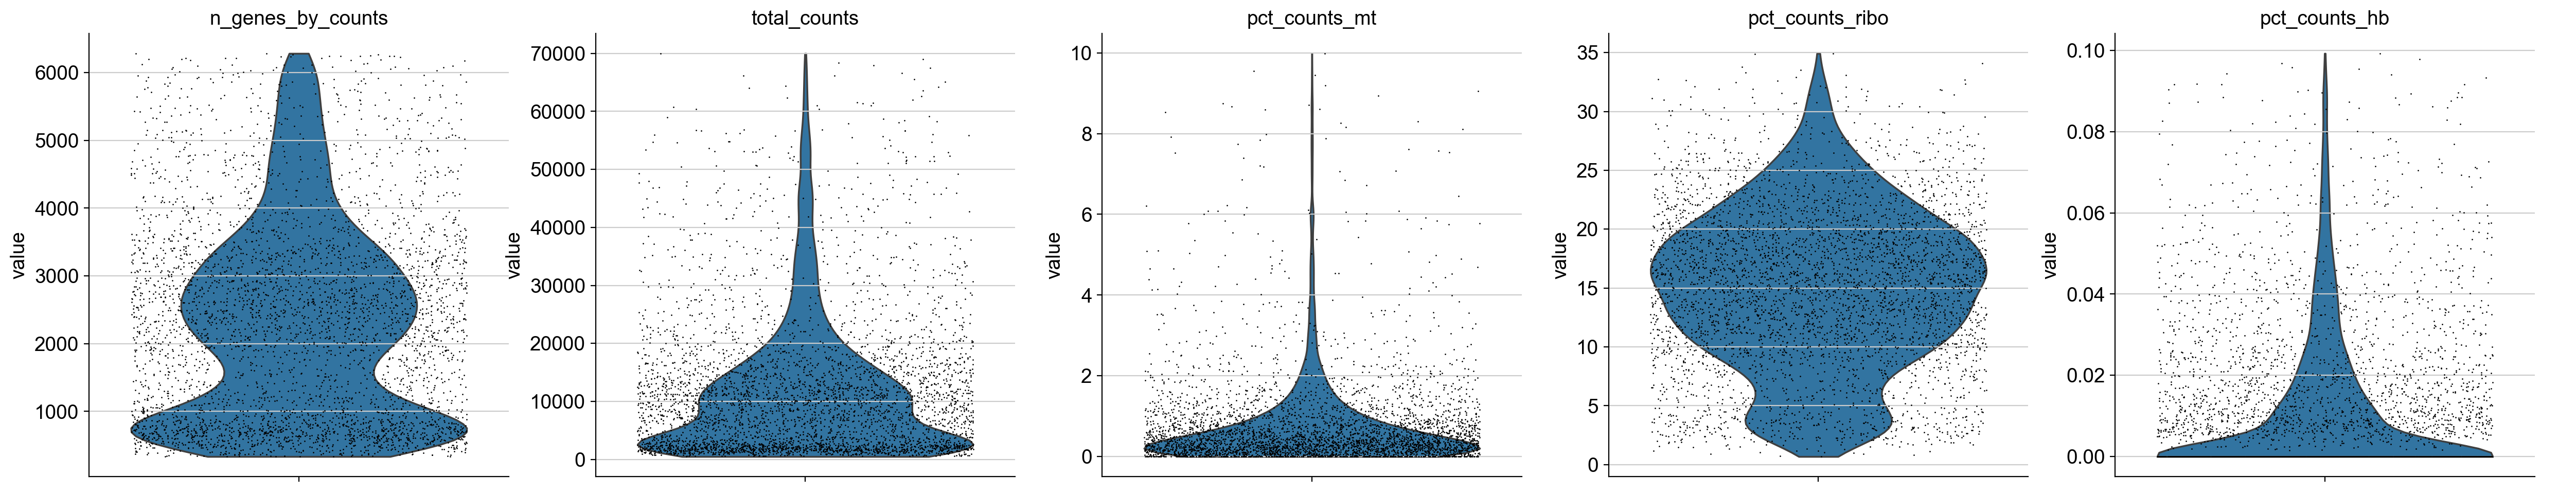

In [87]:
adata4 = adata4[(adata4.obs.n_genes_by_counts < upper_lim) & (adata4.obs.n_genes_by_counts > lower_lim)]
adata4 = adata4[adata4.obs.pct_counts_mt < 10]
adata4 = adata4[adata4.obs.pct_counts_ribo < 35]
adata4 = adata4[adata4.obs['pct_counts_hb'] < 0.1].copy()

sc.pl.violin(adata4, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, multi_panel=True)

In [88]:
adata4

AnnData object with n_obs × n_vars = 4149 × 41464
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [89]:
import scanpy as sc

# Assuming adatas is a list containing your individual AnnData objects: [adata1, adata2, adata3, adata4]
adatas = [adata1, adata2, adata3, adata4]

# Define sample names
sample_names = [ 'V1', 'V2', 'T1', 'T2']


# Concatenate the list of AnnData objects into a single AnnData object
adata = sc.concat(adatas, join='outer', label='Sample', keys=sample_names)


In [90]:
adata

AnnData object with n_obs × n_vars = 16033 × 41464
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'Sample'

In [91]:
sc.pp.filter_genes(adata, min_cells = 10)
adata

AnnData object with n_obs × n_vars = 16033 × 19139
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'Sample'
    var: 'n_cells'

In [92]:
adata.X

<16033x19139 sparse matrix of type '<class 'numpy.float32'>'
	with 38591177 stored elements in Compressed Sparse Row format>

In [93]:
adata.write_h5ad('combinedNEW.h5ad')